# Age and Gender classification
# Baseline Machine Learning Model Training

### Environment Setup

In [1]:
import sys
import os
sys.path
sys.path.append('..')
import pandas as pd
import numpy as np

from utils import batch_loader
from utils import transform_with_ipca, fit_ipca_with_batches
from utils import show_principal_components, show_scree_plot
from utils import show_explained_variance

from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

### Loading the Data

In [2]:
path_data = '../data/merged'
path_labels = '../data/merged/dataset_labels.csv'
df = pd.read_csv(path_labels)

In [3]:
df.sample(5)

,filename,gender,race,age_group
73560,face69899_1_1_3.jpg,1,1,3
45205,face38778_1_3_2.jpg,1,3,2
98469,face97195_0_3_3.jpg,0,3,3
16387,face118002_1_4_3.jpg,1,4,3
22820,face15597_1_0_5.jpg,1,0,5


In [4]:
filenames = df['filename'].values

#### Batching Setup

In [5]:
batch_size = 100
image_size = (200, 200)

In [6]:
data_gen = batch_loader( df, filenames, path_data, batch_size=batch_size, image_size=image_size)

In [7]:
X_batch, y_batch_gender, y_batch_race, y_batch_age = next(data_gen)

In [8]:
print("Batch shapes:", X_batch.shape, y_batch_gender.shape, y_batch_race.shape, y_batch_age.shape)

Batch shapes: (100, 40000) (100,) (100,) (100,)


### Creating ML model

#### Complete Dataset PCA

In [9]:
n_components = 200
batch_size = 2000

data_gen = batch_loader(df, filenames, path_data, batch_size=batch_size, image_size=(200, 200))

ipca = fit_ipca_with_batches(data_gen, n_components=n_components, batch_size=batch_size)

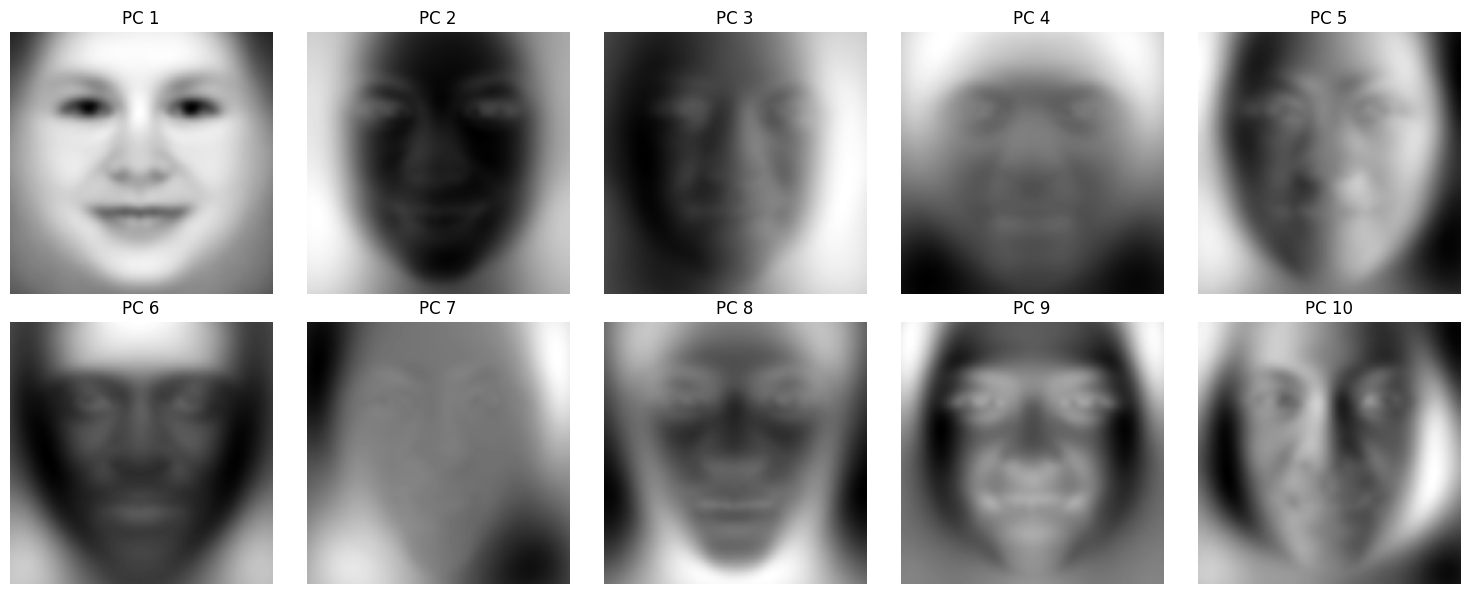

In [10]:
show_principal_components(ipca, num_components=10)

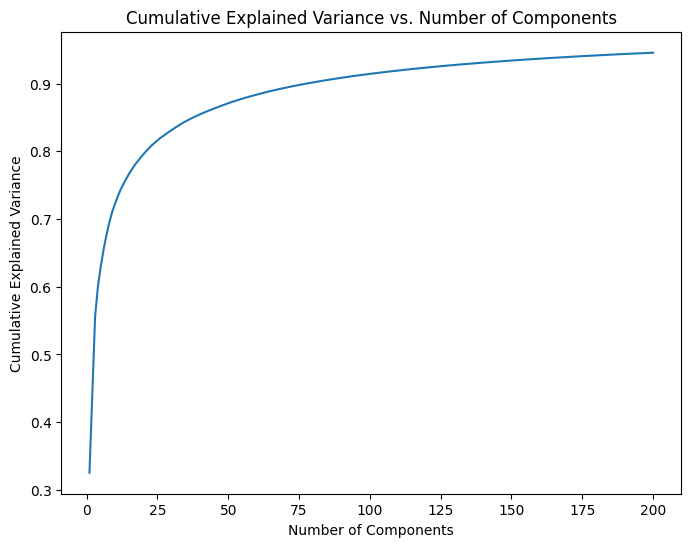

Total Explained Variance: 0.9457


In [11]:
show_explained_variance(ipca)

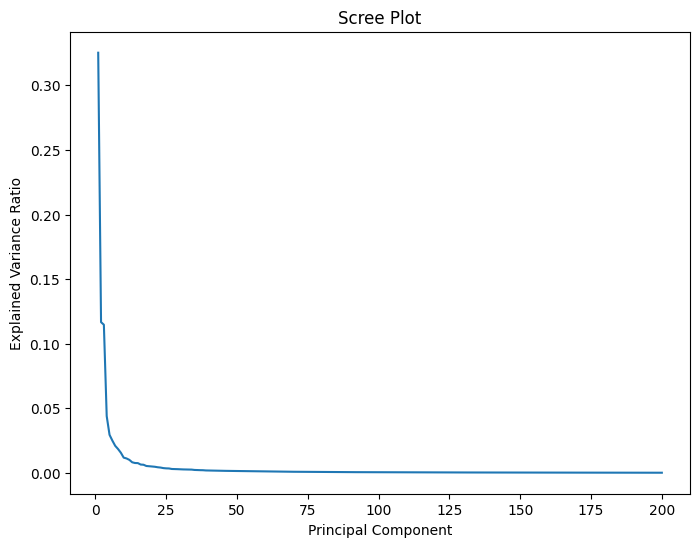

In [12]:
show_scree_plot(ipca)

In [13]:
data_gen_for_transforming = batch_loader(df, filenames, path_data, batch_size=batch_size, image_size=(200, 200))

X_pca = transform_with_ipca(data_gen_for_transforming, ipca)

#### Principle Components that explains 90% of variance

In [33]:
cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # +1 because index starts at 0
print(f"Number of components needed for 90% variance: {n_components_90}")

Number of components needed for 90% variance: 78


In [34]:
X_pca_cut = X_pca[:, :78]

#### Splitting the Data

In [36]:
y_gender = df['gender'].astype(int).values
y_race = df['race'].astype(int).values
y_age = df['age_group'].astype(int).values
y_combined = np.column_stack([y_gender, y_race, y_age])

X_train, X_temp, y_train_combined, y_temp_combined = train_test_split(
    X_pca_cut, y_combined, test_size=0.3, random_state=42)

X_val, X_test, y_val_combined, y_test_combined = train_test_split(
    X_temp, y_temp_combined, test_size=0.5, random_state=42)

#### Calculating the Class Weights

In [37]:
unique_gender_classes = np.unique(y_gender)
class_weights_gender = compute_class_weight('balanced', classes=unique_gender_classes, y=y_gender)
class_weights_gender_dict = dict(zip(unique_gender_classes, class_weights_gender))
print("Gender class weights:", class_weights_gender_dict)

unique_race_classes = np.unique(y_race)
class_weights_race = compute_class_weight('balanced', classes=unique_race_classes, y=y_race)
class_weights_race_dict = dict(zip(unique_race_classes, class_weights_race))
print("Race class weights:", class_weights_race_dict)

unique_age_classes = np.unique(y_age)
class_weights_age = compute_class_weight('balanced', classes=unique_age_classes, y=y_age)
class_weights_age_dict = dict(zip(unique_age_classes, class_weights_age))
print("Age group class weights:", class_weights_age_dict)

Gender class weights: {0: 0.9677713037144938, 1: 1.0344492020241338}
Race class weights: {0: 0.8337599075297226, 1: 1.3169666145018257, 2: 0.8135094856406332, 3: 1.3529608788853162, 4: 0.9320258421781265}
Age group class weights: {0: 4.242176013442554, 1: 1.0072311988829044, 2: 1.1154742574366792, 3: 0.36857588133743574, 4: 0.524129089852184, 5: 0.964628228641296, 6: 1.4401945264478957, 7: 3.0227789750957856, 8: 5.206754318123227}


### Defining ML model using RandomForestClassifier

In [38]:
class CustomMultiOutputClassifier:
    def __init__(self, gender_weights, race_weights, age_weights):
        self.gender_rf = RandomForestClassifier(class_weight=gender_weights)
        self.race_rf = RandomForestClassifier(class_weight=race_weights)
        self.age_rf = RandomForestClassifier(class_weight=age_weights)

    def fit(self, X, y):
        self.gender_rf.fit(X, y[:, 0])  # Gender
        self.race_rf.fit(X, y[:, 1])    # Race
        self.age_rf.fit(X, y[:, 2])     # Age group

    def predict(self, X):
        y_pred_gender = self.gender_rf.predict(X)
        y_pred_race = self.race_rf.predict(X)
        y_pred_age = self.age_rf.predict(X)
        return np.column_stack([y_pred_gender, y_pred_race, y_pred_age])

In [39]:
print(y_gender.dtype, y_race.dtype, y_age.dtype)

int32 int32 int32


In [40]:
print(np.unique(y_gender))
print(np.unique(y_race))
print(np.unique(y_age))

[0 1]
[0 1 2 3 4]
[0 1 2 3 4 5 6 7 8]


In [41]:
print("Missing values in gender:", df['gender'].isnull().sum())
print("Missing values in race:", df['race'].isnull().sum())
print("Missing values in age group:", df['age_group'].isnull().sum())

Missing values in gender: 0
Missing values in race: 0
Missing values in age group: 0


#### Fitting the Model

In [42]:
gender_weights = {0: class_weights_gender_dict[0], 1: class_weights_gender_dict[1]}
race_weights = class_weights_race_dict
age_weights = class_weights_age_dict

multi_target_model = CustomMultiOutputClassifier(
    gender_weights=gender_weights,
    race_weights=race_weights,
    age_weights=age_weights
)

multi_target_model.fit(X_train, y_train_combined)

### Evaluation of RandomForestClassifier Model

In [44]:
y_pred_test_combined = multi_target_model.predict(X_test)

In [45]:
print("Test Gender Classification Report:")
print(classification_report(y_test_combined[:, 0], y_pred_test_combined[:, 0]))

print("Test Race Classification Report:")
print(classification_report(y_test_combined[:, 1], y_pred_test_combined[:, 1]))

print("Test Age Group Classification Report:")
print(classification_report(y_test_combined[:, 2], y_pred_test_combined[:, 2]))

Test Gender Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.66      0.58      7917
           1       0.48      0.35      0.40      7231

    accuracy                           0.51     15148
   macro avg       0.50      0.50      0.49     15148
weighted avg       0.50      0.51      0.50     15148

Test Race Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.38      0.29      3657
           1       0.16      0.02      0.03      2315
           2       0.24      0.42      0.31      3692
           3       0.18      0.02      0.03      2232
           4       0.21      0.16      0.18      3252

    accuracy                           0.23     15148
   macro avg       0.21      0.20      0.17     15148
weighted avg       0.21      0.23      0.19     15148

Test Age Group Classification Report:
              precision    recall  f1-score   support

           0       0.14

### XGBOOST Model Training


In [46]:
class CustomXGBClassifier:
    def __init__(self, gender_weights, race_weights, age_weights):
        self.gender_xgb = XGBClassifier(
            scale_pos_weight=gender_weights[0] / gender_weights[1]
        )
        
        self.race_weights = race_weights
        self.age_weights = age_weights

        self.race_xgb = XGBClassifier(objective='multi:softmax', num_class=len(race_weights))
        self.age_xgb = XGBClassifier(objective='multi:softmax', num_class=len(age_weights))

    def fit(self, X, y):
        self.gender_xgb.fit(X, y[:, 0])
        race_sample_weights = np.array([self.race_weights[class_] for class_ in y[:, 1]])
        age_sample_weights = np.array([self.age_weights[class_] for class_ in y[:, 2]])
        self.race_xgb.fit(X, y[:, 1], sample_weight=race_sample_weights)
        self.age_xgb.fit(X, y[:, 2], sample_weight=age_sample_weights)

    def predict(self, X):
        y_pred_gender = self.gender_xgb.predict(X)
        y_pred_race = self.race_xgb.predict(X)
        y_pred_age = self.age_xgb.predict(X)
        return np.column_stack([y_pred_gender, y_pred_race, y_pred_age])

In [47]:
gender_weights = class_weights_gender_dict
race_weights = class_weights_race_dict
age_weights = class_weights_age_dict

XGB_model = CustomXGBClassifier(
    gender_weights=gender_weights,
    race_weights=race_weights,
    age_weights=age_weights
)

XGB_model.fit(X_train, y_train_combined)

y_pred = XGB_model.predict(X_test)

In [48]:
y_pred_test_combined = XGB_model.predict(X_test)

from sklearn.metrics import classification_report

print("Test Gender Classification Report:")
print(classification_report(y_test_combined[:, 0], y_pred_test_combined[:, 0]))

print("Test Race Classification Report:")
print(classification_report(y_test_combined[:, 1], y_pred_test_combined[:, 1]))

print("Test Age Group Classification Report:")
print(classification_report(y_test_combined[:, 2], y_pred_test_combined[:, 2]))

Test Gender Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57      7917
           1       0.48      0.38      0.43      7231

    accuracy                           0.51     15148
   macro avg       0.50      0.50      0.50     15148
weighted avg       0.51      0.51      0.50     15148

Test Race Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.22      0.23      3657
           1       0.15      0.16      0.15      2315
           2       0.24      0.23      0.23      3692
           3       0.14      0.16      0.15      2232
           4       0.22      0.22      0.22      3252

    accuracy                           0.20     15148
   macro avg       0.20      0.20      0.20     15148
weighted avg       0.21      0.20      0.20     15148

Test Age Group Classification Report:
              precision    recall  f1-score   support

           0       0.02

In [50]:
gender_param_grid = {
    'max_depth': [3,  7, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 500, 1000]
}

gender_grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=gender_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)

gender_grid_search.fit(X_train, y_train_combined[:, 0])

best_gender_model = gender_grid_search.best_estimator_
print("Best parameters for Gender Classifier:", gender_grid_search.best_params_)
print("Best score for Gender Classifier:", gender_grid_search.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Gender Classifier: {'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 1000}
Best score for Gender Classifier: 0.5070899033488997


In [51]:
race_param_grid = {
    'max_depth': [3,  7, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 500, 1000]
}

race_sample_weights = np.array([class_weights_race_dict[class_] for class_ in y_train_combined[:, 1]])

race_grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=len(class_weights_race_dict)),
    param_grid=race_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)

race_grid_search.fit(X_train, y_train_combined[:, 1], sample_weight=race_sample_weights)

best_race_model = race_grid_search.best_estimator_
print("Best parameters for Race Classifier:", race_grid_search.best_params_)
print("Best score for Race Classifier:", race_grid_search.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Race Classifier: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500}
Best score for Race Classifier: 0.21083909247915367


In [52]:
age_param_grid = {
    'max_depth': [3,  7, 15],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 500, 1000]
}

age_sample_weights = np.array([class_weights_age_dict[class_] for class_ in y_train_combined[:, 2]])

age_grid_search = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=len(class_weights_age_dict)),
    param_grid=age_param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)

age_grid_search.fit(X_train, y_train_combined[:, 2], sample_weight=age_sample_weights)

best_age_model = age_grid_search.best_estimator_
print("Best parameters for Age Group Classifier:", age_grid_search.best_params_)
print("Best score for Age Group Classifier:", age_grid_search.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Age Group Classifier: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Best score for Age Group Classifier: 0.19151492946905616


In [53]:
custom_xgb_model = CustomXGBClassifier(
    gender_weights=class_weights_gender_dict,
    race_weights=class_weights_race_dict,
    age_weights=class_weights_age_dict
)

custom_xgb_model.gender_xgb = best_gender_model
custom_xgb_model.race_xgb = best_race_model
custom_xgb_model.age_xgb = best_age_model


### Tuned Model Performance

In [54]:
custom_xgb_model.fit(X_train, y_train_combined)

y_pred_test_combined = custom_xgb_model.predict(X_test)

print("Test Gender Classification Report:")
print(classification_report(y_test_combined[:, 0], y_pred_test_combined[:, 0]))

print("Test Race Classification Report:")
print(classification_report(y_test_combined[:, 1], y_pred_test_combined[:, 1]))

print("Test Age Group Classification Report:")
print(classification_report(y_test_combined[:, 2], y_pred_test_combined[:, 2]))

Test Gender Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54      7917
           1       0.47      0.43      0.45      7231

    accuracy                           0.50     15148
   macro avg       0.50      0.50      0.50     15148
weighted avg       0.50      0.50      0.50     15148

Test Race Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.29      0.26      3657
           1       0.14      0.08      0.11      2315
           2       0.23      0.30      0.26      3692
           3       0.16      0.09      0.12      2232
           4       0.22      0.22      0.22      3252

    accuracy                           0.22     15148
   macro avg       0.20      0.20      0.19     15148
weighted avg       0.21      0.22      0.21     15148

Test Age Group Classification Report:
              precision    recall  f1-score   support

           0       0.03